# Applying IntelligentElement to relational data

Relational data uses keys to access nested structures and retrieve them across database tables.

For example: a client record from a table may have `client_id`, that is used to index and retrieve multiple rows from another datatable.

## Imports

Let us import the packages that will be used.

In [1]:
#misc
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import zipfile

#learning
from keras import Model
from keras import layers as L
from keras import backend as K
import numpy as np

#add two parent levels to path
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(0,parentdir) 

%load_ext autoreload
%autoreload 2

import IntelligentElement as IE

Using TensorFlow backend.


# Load Data

## Open .csv files from zip

In [2]:
zip_data = zipfile.ZipFile('elodata/elo_data.zip', 'r')
allfiles = [f for f in zip_data.namelist()]
allfiles

['merchants.csv',
 'sample_submission.csv',
 'new_merchant_transactions.csv',
 'test.csv',
 'train.csv',
 'Data_Dictionary.xlsx',
 'historical_transactions.csv']

In [3]:
train_data = pd.read_csv(zip_data.open('train.csv'), parse_dates=["first_active_month"]).fillna(0)
test_data = pd.read_csv(zip_data.open('test.csv'), parse_dates=["first_active_month"]).fillna(0)
train_data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
hist_trans = pd.read_csv(zip_data.open('historical_transactions.csv'), index_col='card_id', parse_dates=["purchase_date"]).fillna(0)
hist_trans = hist_trans.sort_index()
hist_trans.head()

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
card_id,,,,,,,,,,,,,
C_ID_00007093c1,Y,244,N,1,B,222,M_ID_ee8fcd02ca,-2,-0.353213,2017-12-07 17:48:54,3.0,2,21
C_ID_00007093c1,Y,244,N,1,B,45,M_ID_2efbd71a00,-1,-0.668770,2018-01-08 18:13:40,3.0,2,18
C_ID_00007093c1,N,244,N,1,B,373,M_ID_490fc654fb,-6,-0.596643,2017-08-28 11:46:28,3.0,2,18
C_ID_00007093c1,Y,244,N,2,C,45,M_ID_0379adb435,-7,-0.520007,2017-07-06 12:41:24,3.0,2,18
C_ID_00007093c1,Y,244,N,1,B,307,M_ID_9400cf2342,-12,-0.572600,2017-02-16 15:37:58,3.0,2,19


In [5]:
new_trans = pd.read_csv(zip_data.open('new_merchant_transactions.csv'), index_col='card_id', parse_dates=["purchase_date"]).fillna(0)
new_trans = new_trans.sort_index()
new_trans.head()

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
card_id,,,,,,,,,,,,,
C_ID_00007093c1,Y,76,N,1,B,222,M_ID_08f01305af,2,-0.671775,2018-04-03 11:13:35,3.0,2,21
C_ID_00007093c1,Y,69,N,1,B,879,M_ID_00a6ca8a8a,2,-0.656749,2018-04-09 16:23:59,1.0,9,29
C_ID_0001238066,Y,333,N,3,C,607,M_ID_a5a61c543e,1,-0.078318,2018-03-24 17:02:00,1.0,9,29
C_ID_0001238066,Y,69,N,1,B,879,M_ID_00a6ca8a8a,1,-0.676433,2018-03-30 00:18:46,1.0,9,29
C_ID_0001238066,Y,291,N,1,B,278,M_ID_d855771cd9,1,-0.694631,2018-03-22 09:20:18,1.0,9,37


In [6]:
mercs = pd.read_csv(zip_data.open('merchants.csv'), index_col='merchant_id').fillna(0)
mercs = mercs.sort_index()
mercs.head()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_000025127f,14602,80,37,-0.057471,-0.057471,N,E,E,1.29,1.880342,...,1.26,2.228632,6,1.08,2.089744,12,Y,69,9,1.0
M_ID_0000699140,19420,87,27,-0.057471,-0.057471,N,D,D,0.99,0.997832,...,1.04,1.002168,6,1.24,1.154878,12,N,48,9,1.0
M_ID_00006a5552,52848,178,29,-0.057471,-0.057471,N,E,E,1.21,1.000000,...,1.18,1.000000,6,1.22,1.035714,12,N,64,15,1.0
M_ID_000087311e,44655,206,1,-0.057471,-0.057471,Y,D,E,0.93,1.314815,...,0.95,1.300926,6,0.78,1.261574,12,Y,-1,-1,0.0
M_ID_0000ab0b2d,35761,367,16,-0.057471,-0.057471,N,D,D,1.05,1.089897,...,0.99,1.057279,6,1.06,1.135640,12,N,-1,9,1.0


In [7]:
train_data.loc[1].card_id in hist_trans.index

True

In [8]:
hist_trans.loc[train_data.loc[2].card_id]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
card_id,,,,,,,,,,,,,
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-7,-0.681588,2017-07-21 14:00:42,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-4,-0.694826,2017-10-11 20:18:47,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,80,M_ID_522bd82b6f,-13,-0.694465,2017-01-27 22:14:29,5.0,5,37
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-9,-0.715457,2017-05-25 21:12:29,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-12,-0.637515,2017-02-23 19:32:42,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-6,-0.682504,2017-08-26 21:01:42,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-10,-0.712677,2017-04-22 19:37:49,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-10,-0.657605,2017-04-21 11:24:44,5.0,5,33
C_ID_d639edf6cd,Y,143,N,0,A,705,M_ID_5634fd83e0,-12,-0.673578,2017-02-20 19:13:49,5.0,5,33


## Data Preprocessing

### train.csv / test.csv

(array([2.7521e+04, 2.4859e+04, 2.6807e+04, 2.8871e+04, 2.2287e+04,
        1.6129e+04, 1.1476e+04, 8.7340e+03, 6.2480e+03, 4.9170e+03,
        3.8250e+03, 3.0890e+03, 2.5010e+03, 2.0740e+03, 1.7990e+03,
        1.5280e+03, 1.2480e+03, 1.0650e+03, 9.4000e+02, 8.1900e+02,
        7.2100e+02, 5.6300e+02, 5.0200e+02, 3.9700e+02, 3.9000e+02,
        3.3100e+02, 3.1200e+02, 2.5600e+02, 2.1200e+02, 2.1800e+02,
        1.4900e+02, 1.6000e+02, 1.4300e+02, 1.0200e+02, 9.6000e+01,
        8.3000e+01, 8.5000e+01, 6.8000e+01, 5.8000e+01, 5.4000e+01,
        4.6000e+01, 2.8000e+01, 2.6000e+01, 2.2000e+01, 2.0000e+01,
        1.2000e+01, 1.0000e+01, 1.4000e+01, 8.0000e+00, 8.0000e+00,
        7.0000e+00, 1.0000e+01, 7.0000e+00, 6.0000e+00, 4.0000e+00,
        4.0000e+00, 5.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

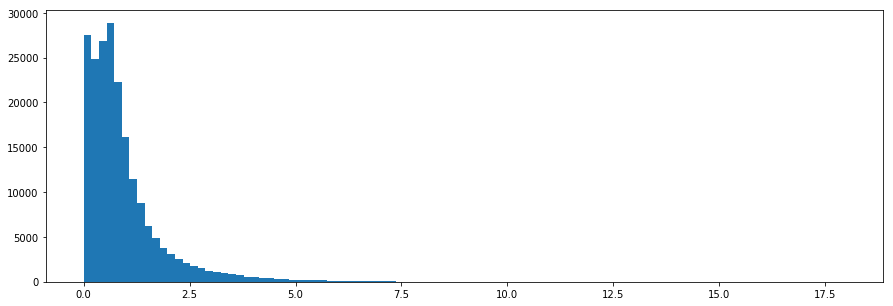

In [9]:
#get labels
y_train = train_data['target'].tolist()
y_train = np.exp(y_train) - np.exp(min(y_train))
y_train = np.log(1+y_train)

plt.figure(figsize=(15,5))
plt.hist(y_train,bins=100)

In [10]:
from sklearn.preprocessing import LabelEncoder
def preproc_data(df):
    ans = df[ ['card_id', 'feature_3'] ]
    
    dum1 = pd.get_dummies(train_data['feature_1'],prefix='f1')
    ans = pd.concat([ans,dum1],axis=1)

    dum2 = pd.get_dummies(train_data['feature_2'],prefix='f2')
    ans = pd.concat([ans,dum2],axis=1)
    
    return ans

train_data_prep = preproc_data(train_data)
train_data_prep.head()

,card_id,feature_3,f1_1,f1_2,f1_3,f1_4,f1_5,f2_1,f2_2,f2_3
0,C_ID_92a2005557,1,0,0,0,0,1,0,1,0
1,C_ID_3d0044924f,0,0,0,0,1,0,1,0,0
2,C_ID_d639edf6cd,0,0,1,0,0,0,0,1,0
3,C_ID_186d6a6901,0,0,0,0,1,0,0,0,1
4,C_ID_cdbd2c0db2,0,1,0,0,0,0,0,0,1


### history.csv

In [11]:
#hist_trans = hist_trans.head(1000)

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'

#label_encoders
history_categoricals = ['category_3', 'category_2', 'category_1', 'merchant_category_id', 
                        'subsector_id','city_id','state_id']
def preproc_history(df, label_encoders = None):
    
    if label_encoders is None:
        lbl_encs = {}
    else:
        lbl_encs = label_encoders
    
    ans = df[ ['merchant_id', 'month_lag', 'purchase_amount'] ]
    ans['month_lag'] = -ans['month_lag']/13
    ans['authorized_flag'] = df.authorized_flag.apply(lambda x : int(x=='Y'))
    
    ans['purchase_dayofweek'] = df.purchase_date.apply(lambda x : x.dayofweek)
    ans['purchase_dayofmonth'] = df.purchase_date.apply(lambda x : x.day)
    ans['purchase_month'] = df.purchase_date.apply(lambda x : x.month)

    for col in history_categoricals:
        if label_encoders is None:
            lblenc=LabelEncoder()
            ans[col] = lblenc.fit_transform(df[col].tolist())
            lbl_encs[col]=lblenc
        else:
            ans[col] = label_encoders[col].transform(df[col].tolist())
    
    return ans, lbl_encs

In [13]:
hist_trans_prep, hist_trans_lbl_encs=preproc_history(hist_trans)
hist_trans_prep.head()

,merchant_id,month_lag,purchase_amount,authorized_flag,purchase_dayofweek,purchase_dayofmonth,purchase_month,category_3,category_2,category_1,merchant_category_id,subsector_id,city_id,state_id
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,M_ID_ee8fcd02ca,0.153846,-0.353213,1,3,7,12,2,3,0,80,20,212,2
C_ID_00007093c1,M_ID_2efbd71a00,0.076923,-0.668770,1,0,8,1,2,3,0,17,17,212,2
C_ID_00007093c1,M_ID_490fc654fb,0.461538,-0.596643,0,0,28,8,2,3,0,135,17,212,2
C_ID_00007093c1,M_ID_0379adb435,0.538462,-0.520007,1,3,6,7,3,3,0,17,17,212,2
C_ID_00007093c1,M_ID_9400cf2342,0.923077,-0.572600,1,3,16,2,2,3,0,108,18,212,2


### new_merchant_transactions.csv

In [14]:
new_trans_prep, new_trans_lbl_encs = preproc_history(new_trans)
new_trans_prep.head()

,merchant_id,month_lag,purchase_amount,authorized_flag,purchase_dayofweek,purchase_dayofmonth,purchase_month,category_3,category_2,category_1,merchant_category_id,subsector_id,city_id,state_id
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,M_ID_08f01305af,-0.153846,-0.671775,1,1,3,4,2,3,0,77,20,64,2
C_ID_00007093c1,M_ID_00a6ca8a8a,-0.153846,-0.656749,1,0,9,4,2,1,0,308,28,58,9
C_ID_0001238066,M_ID_a5a61c543e,-0.076923,-0.078318,1,5,24,3,3,1,0,223,28,294,9
C_ID_0001238066,M_ID_00a6ca8a8a,-0.076923,-0.676433,1,4,30,3,2,1,0,308,28,58,9
C_ID_0001238066,M_ID_d855771cd9,-0.076923,-0.694631,1,3,22,3,2,1,0,96,36,256,9


### merchants.csv

In [15]:
merc_categoricals = ['category_4', 'category_2', 'category_1', 'city_id','state_id', 'merchant_group_id',
                     'merchant_category_id', 'subsector_id', 'most_recent_sales_range', 'most_recent_purchases_range']
def preproc_mercs(df):
    
    lbl_encs = {}
    
    ans = df[ ['numerical_1', 'numerical_2', 
               'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
               'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
               'avg_sales_lag12','avg_purchases_lag12','active_months_lag12'] ]

    ans['avg_sales_lag3'] = np.log(1+ans['avg_sales_lag3'])
    ans['avg_sales_lag6'] = np.log(1+ans['avg_sales_lag6'])
    ans['avg_sales_lag12'] = np.log(1+ans['avg_sales_lag12'])
    ans['avg_purchases_lag3'] = np.log(1+np.clip(ans['avg_purchases_lag3'],0,1e5))
    ans['avg_purchases_lag12'] = np.log(1+np.clip(ans['avg_purchases_lag12'],0,1e5))
    ans['avg_purchases_lag6'] = np.log(1+np.clip(ans['avg_purchases_lag6'],0,1e5))
    ans['numerical_1'] = ans['numerical_1']/25.
    ans['numerical_2'] = ans['numerical_2']/25.
    ans['active_months_lag3'] = ans['active_months_lag3']/12.
    ans['active_months_lag12'] = ans['active_months_lag12']/12.
    ans['active_months_lag6'] = ans['active_months_lag6']/12.
    

    for col in merc_categoricals:
        lblenc=LabelEncoder()
        ans[col] = lblenc.fit_transform(df[col].tolist())
        lbl_encs[col]=lblenc
    
    return ans, lbl_encs

In [16]:
mercs_prep, mercs_lblencs = preproc_mercs(mercs)
mercs_prep.head()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,...,category_4,category_2,category_1,city_id,state_id,merchant_group_id,merchant_category_id,subsector_id,most_recent_sales_range,most_recent_purchases_range
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_000025127f,-0.002299,-0.002299,0.828552,1.057909,0.25,0.815365,1.172059,0.5,0.732368,1.128088,...,1,1,0,54,9,14418,29,36,4,4
M_ID_0000699140,-0.002299,-0.002299,0.688135,0.692063,0.25,0.712950,0.694231,0.5,0.806476,0.767734,...,0,1,0,39,9,19167,33,26,3,3
M_ID_00006a5552,-0.002299,-0.002299,0.792993,0.693147,0.25,0.779325,0.693147,0.5,0.797507,0.710847,...,0,1,0,50,15,51892,59,28,4,4
M_ID_000087311e,-0.002299,-0.002299,0.657520,0.839330,0.25,0.667829,0.833312,0.5,0.576613,0.816061,...,1,0,1,0,0,43899,71,1,3,4
M_ID_0000ab0b2d,-0.002299,-0.002299,0.717840,0.737115,0.25,0.688135,0.721384,0.5,0.722706,0.758767,...,0,1,0,0,9,35218,130,15,3,3


# Build IntelligentElement classes

In [17]:
x_train = train_data.index.tolist()

In [78]:
n_val=int( 0.1*len(y_train) )

x_val = x_train[0:n_val]
y_val = y_train[0:n_val]

x_train = x_train[n_val:]
y_train = y_train[n_val:]

## history

In [87]:
def get_hist_info(x):
    row = train_data_prep.iloc[x]
    card_id = row.card_id
    #card_id = 'C_ID_0001238066' #train_data_prep.iloc[x].card_id
    
    #print(card_id)
    
    idx0 = hist_trans_prep.index.searchsorted(card_id, side='left')
    idxf = hist_trans_prep.index.searchsorted(card_id, side='right')
    
    #print('{} {}'.format(idx0,idxf))
    
    df_slice = hist_trans_prep.iloc[slice(idx0, idxf)].sort_values(by=['month_lag'])
    df_slice = df_slice.drop(columns = ['merchant_id'])
    df_slice['pad'] = 1 #identifies that this info exists, ie, was not padded
    
    if idx0==idxf:
        return np.zeros( (1,len(df_slice.columns)) )
    else:
        return np.array(df_slice.values)

In [88]:
temp = get_hist_info(0)
inp_shape = (None, temp.shape[1])

########
# Model
########
inp = L.Input(inp_shape)

#numericals
x = L.Lambda(lambda q: q[:, :, 0:3])(inp)

#deal with categoricals
vals=[x]

curval = L.Lambda(lambda q: q[:, :, 3:4])(inp) #dayofweek
curval = L.Embedding(7,4)(curval)
curval = L.Lambda(lambda q: K.squeeze(q,axis=2) )(curval)
vals.append(curval)

curval = L.Lambda(lambda q: q[:, :, 4:5])(inp) #dayofmonth
curval = L.Embedding(31,4)(curval)
curval = L.Lambda(lambda q: K.squeeze(q,axis=2) )(curval)
vals.append(curval)

curval = L.Lambda(lambda q: q[:, :, 5:6])(inp) #month
curval = L.Embedding(12,4)(curval)
curval = L.Lambda(lambda q: K.squeeze(q,axis=2) )(curval)
vals.append(curval)


for k in range(len(history_categoricals)):
    dict_size = len(set(hist_trans_lbl_encs[history_categoricals[k]].classes_))
    embdim = int(np.sqrt(dict_size))+2

    #print(history_categoricals[k])
    #print( embdim )
    
    pos=k+6
    curval = L.Lambda(lambda q: q[:, :, pos:pos+1])(inp)
    
    curval = L.Embedding(dict_size, embdim)(curval)
    curval = L.Lambda(lambda q: K.squeeze(q,axis=2) )(curval)
    
    vals.append(curval)
    
    
x = L.Concatenate()(vals)
x = L.Bidirectional(L.CuDNNLSTM(32))(x)

hist_model = Model(inputs=inp, outputs=x)
#hist_model.summary()


#########
# IE
#########

hist_ie = IE.IntelligentElement(x_train, hist_model, inp_shape, preprocess_function=get_hist_info, val_data=x_val, name='hist_ie')

m, ii, oo = hist_ie.retrieve_model_inputs_outputs()
print('\n\nRetrieved model')
m.summary()



Retrieved model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_hist_ie (InputLayer)     (None, None, 14)          0         
_________________________________________________________________
m_hist_ie (Model)            (None, 16)                18252     
Total params: 18,252
Trainable params: 18,252
Non-trainable params: 0
_________________________________________________________________


In [89]:
hist_ie.get_batch([2,12,46])[0].shape

(3, 267, 14)

In [90]:
hist_ie.get_batch([2,12,46], from_set='val')[0].shape

(3, 114, 14)

## root

In [92]:
def get_train_info(x):
    row = train_data_prep.iloc[x]
    card_id = row.card_id
    row = row.drop('card_id')
    return np.array(row.tolist()).astype(int)

root_feats = hist_ie.model.output_shape[-1]+get_train_info(0).shape[0]
root_shape = (get_train_info(0).shape[0],)

inp = L.Input( (root_feats,) ) 
x=inp
for k in range(4):
    x = L.Dense(4*root_feats, activation='relu')(x)
x = L.Dense(1)(x)

root_model = Model(inputs=inp, outputs=x)
root_model.summary()

#########
# IE
#########

root_ie = IE.IntelligentElement(x_train, root_model, root_shape, preprocess_function=get_train_info, val_data=x_val,
                                children_ie=[hist_ie], name='root_ie')

m, ii, oo = root_ie.retrieve_model_inputs_outputs()
print('\n\nRetrieved model')
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 25)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 75)                1950      
_________________________________________________________________
dense_38 (Dense)             (None, 75)                5700      
_________________________________________________________________
dense_39 (Dense)             (None, 75)                5700      
_________________________________________________________________
dense_40 (Dense)             (None, 75)                5700      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 76        
Total params: 19,126
Trainable params: 19,126
Non-trainable params: 0
_________________________________________________________________


Retr

In [93]:
len(root_ie.get_batch([1,10,20]))

2

# Data Generation and Model Training

In [94]:
train_gen = IE.IEDataGenerator(root_ie, y_train, labeltype=float)
val_gen   = IE.IEDataGenerator(root_ie, y_val, labeltype=float, from_set = 'val')

In [95]:
xx,yy = train_gen.__getitem__(0)

In [96]:
print('{} {} {}'.format(xx[0].shape, xx[1].shape, yy.shape))

(128, 569, 14) (128, 9) (128,)


In [97]:
from keras.optimizers import Adam

#m.compile(optimizer=Adam(lr=4e-4, clipvalue=0.5), loss='mean_squared_error') #, metrics=[mean_iou, 'categorical_accuracy'])

m.compile(optimizer=Adam(lr=4e-4, clipvalue=0.5), loss='logcosh') #, metrics=[mean_iou, 'categorical_accuracy'])


In [99]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=10, verbose=1, monitor='val_loss')
checkpointer = ModelCheckpoint('model-reldb.h5', verbose=1, save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5, verbose=1, monitor='loss')

In [ ]:
results = m.fit_generator(train_gen, epochs=100, 
                          #use_multiprocessing = False, workers=4,
                          validation_data=val_gen,
                          callbacks=[earlystopper, checkpointer, reduce_lr])

Epoch 1/200
1419/1419 [==============================] - 725s 511ms/step - loss: 0.9303 - val_loss: 0.9418

Epoch 00001: val_loss improved from inf to 0.94179, saving model to model-reldb.h5
Epoch 2/200
1418/1419 [============================>.] - ETA: 0s - loss: 0.9182

# Tests and Verifications

In [48]:
new_trans_prep, temp = preproc_history(new_trans)
new_trans_prep.head()

,merchant_id,month_lag,purchase_amount,purchase_dayofweek,purchase_dayofmonth,purchase_month,authorized_flag,category_3,category_2,category_1,merchant_category_id,subsector_id,city_id,state_id
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,M_ID_08f01305af,-0.153846,-0.671775,1,3,4,1,1,2,0,77,20,64,2
C_ID_00007093c1,M_ID_00a6ca8a8a,-0.153846,-0.656749,0,9,4,1,1,0,0,308,28,58,9
C_ID_0001238066,M_ID_a5a61c543e,-0.076923,-0.078318,5,24,3,1,2,0,0,223,28,294,9
C_ID_0001238066,M_ID_00a6ca8a8a,-0.076923,-0.676433,4,30,3,1,1,0,0,308,28,58,9
C_ID_0001238066,M_ID_d855771cd9,-0.076923,-0.694631,3,22,3,1,1,0,0,96,36,256,9


In [113]:
idx = mercs_prep.index.searchsorted('M_ID_0000699140')
mercs_prep.iloc[idx]

numerical_1           -0.002299
numerical_2           -0.002299
avg_sales_lag3         0.688135
avg_purchases_lag3     0.692063
active_months_lag3     0.250000
avg_sales_lag6         0.712950
avg_purchases_lag6     0.694231
active_months_lag6     0.500000
avg_sales_lag12        0.806476
avg_purchases_lag12    0.767734
active_months_lag12    1.000000
Name: M_ID_0000699140, dtype: float64

In [23]:
new_trans.index.searchsorted('C_ID_0001238066', side='left')

2

In [24]:
new_trans.index.searchsorted('C_ID_0001238066', side='right')

28

In [21]:
sl = slice(2,28)

In [22]:
new_trans.iloc[sl]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
card_id,,,,,,,,,,,,,
C_ID_0001238066,Y,333,N,3,C,607,M_ID_a5a61c543e,1,-0.078318,2018-03-24 17:02:00,1.0,9,29
C_ID_0001238066,Y,69,N,1,B,879,M_ID_00a6ca8a8a,1,-0.676433,2018-03-30 00:18:46,1.0,9,29
C_ID_0001238066,Y,291,N,1,B,278,M_ID_d855771cd9,1,-0.694631,2018-03-22 09:20:18,1.0,9,37
C_ID_0001238066,Y,69,N,1,B,278,M_ID_9962ea3faf,2,-0.371245,2018-04-29 01:19:02,1.0,9,37
C_ID_0001238066,Y,169,N,1,B,307,M_ID_a275791cd2,2,-0.530526,2018-04-01 10:54:28,5.0,20,19
C_ID_0001238066,Y,291,N,3,C,607,M_ID_e7a20356e3,1,-0.351786,2018-03-10 18:11:22,1.0,9,29
C_ID_0001238066,Y,333,N,1,B,783,M_ID_a88790a464,1,-0.641722,2018-03-04 13:05:16,1.0,9,19
C_ID_0001238066,Y,314,N,10,C,705,M_ID_edf884cae2,2,-0.566770,2018-04-22 14:46:31,1.0,9,33
C_ID_0001238066,Y,69,N,1,B,606,M_ID_cd2c0b07e9,1,-0.688680,2018-03-24 17:36:19,1.0,9,17


In [11]:
slist = s.tolist()

In [12]:
slist[0:3]

['C_ID_00007093c1', 'C_ID_00007093c1', 'C_ID_0001238066']

In [13]:
train_data.iloc[150]

first_active_month    2017-06-01 00:00:00
card_id                   C_ID_839c8597b8
feature_1                               5
feature_2                               1
feature_3                               1
target                          -0.752845
Name: 150, dtype: object